# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP. 
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [1]:
#adding requirements
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

In [91]:
tr_mcc_codes = pd.read_csv("data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("data/tr_types.csv", sep=";", index_col="tr_type")

transactions = pd.read_csv("data/transactions.csv", index_col="customer_id")
gender = pd.read_csv("data/gender.csv", index_col="customer_id")

# Let's check the data

In [11]:
print(transactions.info(), gender.info())
print(tr_mcc_codes.shape, tr_types.shape, transactions.shape, gender.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849346 entries, 39026145 to 61870738
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tr_datetime  object 
 1   mcc_code     int64  
 2   tr_type      int64  
 3   amount       float64
 4   term_id      object 
dtypes: float64(1), int64(2), object(2)
memory usage: 313.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 6740969 to 82234503
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gender  8400 non-null   float64
dtypes: float64(1)
memory usage: 187.5 KB


(None, None)

In [9]:
print('>>>>transactions\n' , transactions.head(10), '\n')
print('>>>>tr_mcc_codes\n' , tr_mcc_codes.head(10), '\n')
print('>>>>tr_types\n' , tr_types.head(10), '\n')
print('>>>>gender\n' , gender.head(10), '\n')

>>>>transactions
             tr_datetime  mcc_code  tr_type    amount term_id
customer_id                                                 
39026145     0 10:23:26      4814     1030  -2245.92     NaN
39026145     1 10:19:29      6011     7010  56147.89     NaN
39026145     1 10:20:56      4829     2330 -56147.89     NaN
39026145     1 10:39:54      5499     1010  -1392.47     NaN
39026145     2 15:33:42      5499     1010   -920.83     NaN
39026145     2 15:53:49      5541     1010 -14643.37     NaN
39026145     3 15:29:08      5499     1010  -1010.66     NaN
39026145     4 12:11:57      5200     1010  -2829.85     NaN
39026145     5 15:19:19      5499     1010   -628.86     NaN
39026145     6 07:08:31      4814     1030  -5614.79     NaN 

>>>>tr_mcc_codes
                                             mcc_description
mcc_code                                                   
742                                     Ветеринарные услуги
1711      Генеральные подрядчики по вентиляции, те

[4651 3749]


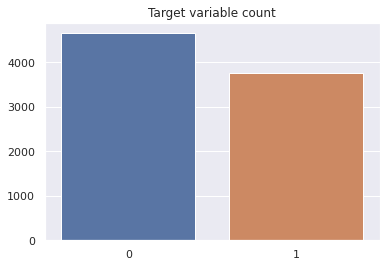

In [78]:
#check the classes distribution
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 

x = gender['gender'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count');
print(x)

# Data exploration


In [112]:
from sklearn.preprocessing import StandardScaler
import numpy as np

#transactions.drop(columns = ['term_id', 'tr_datetime'], inplace = True)
X = transactions
indexes = X.index   
columns = X.columns
X = np.nan_to_num(X)
X = pd.DataFrame(StandardScaler().fit_transform(X), index=indexes, columns=columns)

In [113]:
from sklearn.cluster import KMeans
clasterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clasterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_


In [ ]:
X = pd.concat(X, labels)
#check correlation betweeen labels and genders
#X.corr()


In [114]:
# join gender and transactions into single table by customer_id
Data = pd.merge(X, gender, left_on='customer_id', right_on='customer_id', how='inner')

#drop nan's
#Data.dropna(inplace = True)

#Data consistency check
for ind in Data.index.unique():
    assert len(Data[Data.index == ind]['gender'].unique()) == 1

print(Data.shape)

(5393337, 4)


In [121]:
# Data.dropna(inplace = True)
# y = Data['gender']
# x = Data.drop(columns = ['gender'])
# x.shape

(3730714, 3)

In [42]:
# def CV(samples, Data):
#     for num in samples:
#         data_sample = Data.sample(num)
#         y = data_sample['gender']
#         x = data_sample[['mcc_code']]# 'amount', 'tr_type',]]#'tr_datetime']]
#         print(x.shape)
#         for item in data_sample['mcc_code'].unique():
#             mask = (data_sample['mcc_code'] == item)
#             ratio = sum(data_sample[mask]['gender'] ==  1.0)/len(data_sample[mask]['gender'])
#             if ratio > 0.5:
#                 x.iloc[mask.values, 0] = 1
#             else:
#                 x.iloc[mask.values, 0] = 0

#         from sklearn.model_selection import train_test_split
#         x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

#         from sklearn.linear_model import LogisticRegression
#         from sklearn.metrics import roc_auc_score

#         print('>>>>>>>>>', 'LogisticRegression')
#         lr = LogisticRegression(max_iter=1000)
#         lr.fit(x_train, y_train)
#         print("mean accuracy score on test: " + str(lr.score(x_test, y_test)))
#         print("mean accuracy score on train: "+ str(lr.score(x_train, y_train)))

#         y_pred = lr.predict(x_test)
#         print('roc_auc_score', roc_auc_score(y_test, y_pred))


# samples = [10,100,1000,10000,50000,100000]
# CV(samples, Data)

(10, 1)
>>>>>>>>> LogisticRegression
mean accuracy score on test: 1.0
mean accuracy score on train: 0.875
roc_auc_score 1.0
(100, 1)
>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.65
mean accuracy score on train: 0.7125
roc_auc_score 0.5625


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

(1000, 1)
>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.585
mean accuracy score on train: 0.62375
roc_auc_score 0.5815081508150814


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

(10000, 1)
>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.584
mean accuracy score on train: 0.577375
roc_auc_score 0.5714195089974836


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

(50000, 1)


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.5783
mean accuracy score on train: 0.574375
roc_auc_score 0.5648428058377688
(100000, 1)


/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.57625
mean accuracy score on train: 0.5755
roc_auc_score 0.5450481993201354


In [67]:
# data_sample = Data.sample(100)
# y = data_sample['gender']
# x = data_sample[['mcc_code', 'amount']]#, 'tr_type',]]#'tr_datetime']]
# print(x.shape)

(100, 2)


In [68]:
# for item in data_sample['mcc_code'].unique():
#     mask = (data_sample['mcc_code'] == item)
#     ratio = sum(data_sample[mask]['gender'] ==  1.0)/len(data_sample[mask]['gender'])
#     if ratio > 0.5:
#         x.iloc[mask.values, 0] = 1
#     else:
#         x.iloc[mask.values, 0] = 0

/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/musaev_rv/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

# Let’s start with the basics - Log regression


In [122]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

print('>>>>>>>>>', 'LogisticRegression')
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)
print("mean accuracy score on test: " + str(lr.score(x_test, y_test)))
print("mean accuracy score on train: "+ str(lr.score(x_train, y_train)))

y_pred = lr.predict(x_test)
print('roc_auc_score', roc_auc_score(y_test, y_pred))

>>>>>>>>> LogisticRegression
mean accuracy score on test: 0.5423156151032711
mean accuracy score on train: 0.5430589521911189
roc_auc_score 0.511689495507852


In [125]:
lr.predict_proba(x_test)[:100]

array([[0.53641276, 0.46358724],
       [0.53641276, 0.46358724],
       [0.63670791, 0.36329209],
       [0.51443927, 0.48556073],
       [0.63503636, 0.36496364],
       [0.63672345, 0.36327655],
       [0.5157697 , 0.4842303 ],
       [0.53643705, 0.46356295],
       [0.53641276, 0.46358724],
       [0.63566722, 0.36433278],
       [0.51418305, 0.48581695],
       [0.53641276, 0.46358724],
       [0.6366847 , 0.3633153 ],
       [0.37497389, 0.62502611],
       [0.48989407, 0.51010593],
       [0.62822615, 0.37177385],
       [0.496979  , 0.503021  ],
       [0.51261342, 0.48738658],
       [0.61808126, 0.38191874],
       [0.53641276, 0.46358724],
       [0.5151057 , 0.4848943 ],
       [0.56919274, 0.43080726],
       [0.51417747, 0.48582253],
       [0.51261509, 0.48738491],
       [0.56886927, 0.43113073],
       [0.56910291, 0.43089709],
       [0.53646742, 0.46353258],
       [0.51262822, 0.48737178],
       [0.63670221, 0.36329779],
       [0.50918486, 0.49081514],
       [0.

In [124]:
sum(y_pred == 0)/len(y_pred), sum(y_test == 0)/len(y_test)

(0.885306167852543, 0.5398388780702895)

# Gradient Boosting

In [126]:
from sklearn.ensemble import GradientBoostingClassifier

print('>>>>>>>>>', 'GradientBoostingClassifier')
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0).fit(x_train, y_train)
print("mean accuracy score on test: " + str(clf.score(x_test, y_test)))
print('roc_auc_score', roc_auc_score(y_test, y_pred))

>>>>>>>>> GradientBoostingClassifier
mean accuracy score on test: 0.6040959976840901
roc_auc_score 0.511689495507852


In [127]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('roc_auc_score', roc_auc_score(y_test, y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0, criterion = 'entropy').fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('roc_auc_score', roc_auc_score(y_test, y_pred))

In [ ]:
class DataStratifier():
    def __init__(self) -> None:
        pass

    def stratify(X, y):
        pass
    